# <center> <u> **Impact assessment of the 2023 earthquake in Turkey on the Antakya - Tepehan area**

#### <center> Group 7 - Culot Alexis & Thonnard Julien

This notebook includes all the steps of the damage analysis of the chosen geographical area. Only the landslide analysis has been entirely realized via Python thanks to the different codes provided in the course *LBRAT2104 - Land monitoring and Earth observation*. The two other analyses were produced with the SNAP software from ESA. Finally, the QGIS tool was used for the realization of the maps presented on the final poster. 

## Notebook set-up

### Library installation

In [1]:
import glob, os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.mask
import rasterio.plot
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from pathlib import Path
import re
from osgeo import gdal
from math import *
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

print('All libraries successfully imported!')
print(f'Rasterio : {rasterio.__version__}')

All libraries successfully imported!
Rasterio : 1.1.0


### Set all directories 

In [3]:
computer_path = 'C:/Users/Thonnard Julien/LBRAT2104/'
grp_nb        = '7'

# Directory for all work files
work_path = f'{computer_path}GROUP_{grp_nb}/OUTPUT/'

roi_path = f'{work_path}ROI/'
dwl_path = f'{work_path}DOWNLOAD/'

reflectance_path = f'{work_path}3_L2A_MASKED/'

# For each step of the preprocessing, a folder will be created to store the intermediary files.
resampled_path = f'{work_path}1_L2A_RESAMPLED/'
clipped_path   = f'{work_path}2_L2A_CLIPPED/'
masked_path    = f'{work_path}3_L2A_MASKED/'

Path(resampled_path).mkdir(parents=True, exist_ok=True)
Path(clipped_path).mkdir(parents=True, exist_ok=True)
Path(masked_path).mkdir(parents=True, exist_ok=True)

## Image pre-processing

### Region of interest

In [4]:
crs = 'EPSG:32637'

roi_name     = 'extent_roi'
roi_filename = f'{roi_name}_{crs[5:]}.shp'
roi_file     = f'{roi_path}{roi_filename}'

roi_gdf = gpd.read_file(roi_file)

print(f'ROI shapefile : {roi_file}')

ROI shapefile : C:/Users/Thonnard Julien/LBRAT2104/GROUP_7/OUTPUT/ROI/extent_roi_32637.shp


### Set parameters

In [5]:
band_10m_list = ['B02','B04','B08']

In [6]:
# We will upscale the image by 2: 20m --> 10m
upscale_factor = 2

# As SCL is categorical data, we MUST use "nearest neighbor" resampling method
resampling_method_categorical = Resampling.nearest

# As BOA is continuous data, we can use other resampling methods : nearest, bilinear, cubic
resampling_method_continuous = Resampling.bilinear

nodata_val = -10000

### Load of the images

In [7]:
list_L2A = glob.glob(f'{dwl_path}S2*.SAFE')

print(f'{len(list_L2A)} L2A will be pre-processed \n')

for L2A_safe in list_L2A:
    L2A_name = os.path.basename(L2A_safe)
    print(L2A_name)

2 L2A will be pre-processed 

S2A_MSIL2A_20230209T082111_N0509_R121_T37SBA_20230209T115254.SAFE
S2B_MSIL2A_20230125T082129_N0509_R121_T37SBA_20230125T101549.SAFE


### Resample of the images

In [8]:
for L2A_safe in list_L2A:

    im_file_20m = glob.glob(f'{L2A_safe}/GRANULE/*/IMG_DATA/R20m/*_SCL_20m.jp2')[0]
    im_file_20m = im_file_20m.replace('\\','/')

    im_file_10m = f'{resampled_path}{os.path.basename(im_file_20m).replace("20m","10m").replace("jp2","tif")}'
    
    if not os.path.isfile(im_file_10m):

        # Open file
        src = rasterio.open(im_file_20m, "r", driver='JP2OpenJPEG')

        # Resample data to target shape
        resampled_data = src.read(out_shape = (src.count,
                                               int(src.height * upscale_factor),
                                               int(src.width * upscale_factor)
                                               ),
                                  resampling = resampling_method_categorical)

        # Scale image transform
        new_transform = src.transform * src.transform.scale(
            (src.width / resampled_data.shape[-1]),
            (src.height / resampled_data.shape[-2])
        )

        # Update metadata
        profile = src.profile
        profile.update(driver = 'GTiff',
                       width = src.width*upscale_factor,
                       height = src.height*upscale_factor,
                       transform = new_transform)


        # Write resampled image
        dst = rasterio.open(im_file_10m, "w", **profile)
        dst.write(resampled_data)

        # Close rasterio objects
        src.close()
        dst.close()
        
        print(f'--> A new resampled raster file is created : {im_file_10m}')

print('--> All SCL are resampled !')

--> All SCL are resampled !


In [9]:
list_im_to_clip = glob.glob(f'{resampled_path}*_10m.tif')

for band in band_10m_list:

    list_im_to_clip += glob.glob(f'{dwl_path}*.SAFE/GRANULE/*/IMG_DATA/R10m/*{band}_10m.jp2')

print(f'There are {len(list_im_to_clip)} images to clip')

There are 8 images to clip


### Identification of the ROI

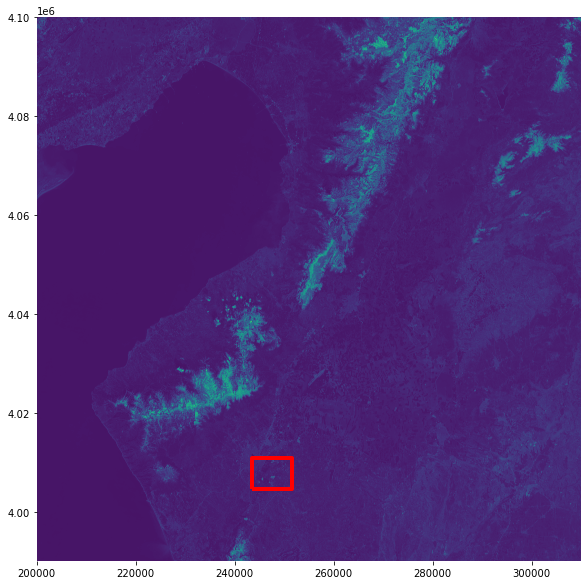

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

# Plot image

# First image of the list
#im_file = list_im_to_clip[0]

# A cloudy image
im_file = [s for s in list_im_to_clip if all(xs in s for xs in ['20230209','B04'])][0]

src = rasterio.open(im_file, "r")
rasterio.plot.show(src, ax=ax)

# Plot vector
roi_gdf.plot(facecolor='none', edgecolor='red', linewidth = 4, ax=ax)

plt.box(False)

### ROI breakdown

In [11]:
for im_file in list_im_to_clip:

    im_file_roi = f'{clipped_path}{os.path.basename(im_file)[:-4]}_ROI.tif'
    
    if not os.path.isfile(im_file_roi):
        
        # Open file
        src = rasterio.open(im_file, "r")

        # Clip the raster to the extent of the shape
        out_image, out_transform = rasterio.mask.mask(src,
                                                      roi_gdf.geometry,
                                                      all_touched=True,
                                                      crop=True)

        # Update metadata
        out_meta = src.meta

        out_meta.update(driver='GTiff',
                        width = out_image.shape[2],
                        height = out_image.shape[1],
                        transform = out_transform)

        # Write clipped image
        dst = rasterio.open(im_file_roi, "w", **out_meta)
        dst.write(out_image)

        # Close rasterio objects
        src.close()
        dst.close()


        print(f'A new raster file is created : {im_file_roi}')

print('--> All images are clipped !')


--> All images are clipped !


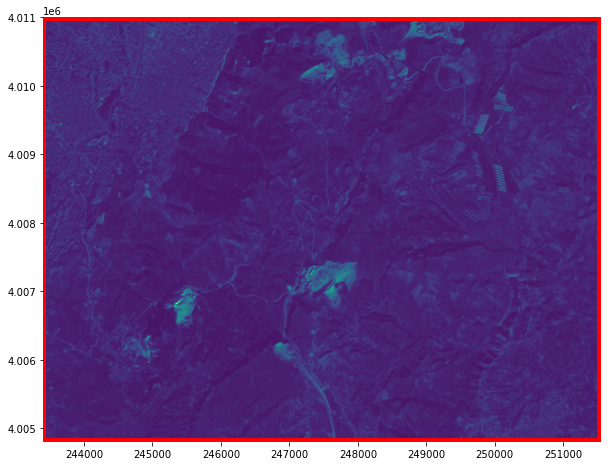

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

# Plot image

# First image of the list
#im_file = glob.glob(f'{clipped_path}*_B*.tif')[0]

# A cloudy image
im_file = glob.glob(f'{clipped_path}*20230209*B04*.tif')[0]


src = rasterio.open(im_file, "r")
rasterio.plot.show(src, ax=ax)

# Plot vector
roi_gdf.plot(facecolor='none', edgecolor='red', linewidth = 6, ax=ax)

plt.box(False)

In [13]:
list_im_ROI = glob.glob(f'{clipped_path}*_B*_ROI.tif')

print(f'There are {len(list_im_ROI)} images where we have to apply SCL map')

There are 6 images where we have to apply SCL map


### Masks

In [14]:
for im_file in list_im_ROI:
    
    # Get date of image
    date = os.path.basename(im_file)[7:7+15]
    
    # Find SCL corresponding to the given reflectances image
    scl_file = glob.glob(f'{clipped_path}*{date}*SCL_10m_ROI.tif')[0]
    scl_file = scl_file.replace('\\','/')
    
    im_file_scl = f'{masked_path}{os.path.basename(im_file)[:-4]}_SCL.tif'

    if not os.path.isfile(im_file_scl):
        
        # Open SCL and change invalid pixels categories by NaN
        src = rasterio.open(scl_file, "r")

        # Read file as numpy array
        SCL = src.read(1)
        src.close()

        #print('Scene Classification map')
        #show(SCL, cmap='Set3')

        SCL = SCL.astype(float)

        SCL[SCL == 0] = np.nan    # No data
        SCL[SCL == 1] = np.nan    # Saturated or defective
        SCL[SCL == 2] = 1         # Dark area pixels
        SCL[SCL == 3] = np.nan    # Cloud shadows
        SCL[SCL == 4] = 1         # Vegetation
        SCL[SCL == 5] = 1         # Not vegetated
        SCL[SCL == 6] = np.nan    # Water
        SCL[SCL == 7] = np.nan    # Unclassified
        SCL[SCL == 8] = np.nan    # Cloud medium probability
        SCL[SCL == 9] = np.nan    # Cloud high probability
        SCL[SCL == 10] = np.nan   # Thin cirrus
        SCL[SCL == 11] = np.nan   # Snow

        # Open file
        src = rasterio.open(im_file, "r")

        # Read file as numpy array
        im = src.read(1)

        # Update metadata
        profile = src.profile
        profile.update(dtype=rasterio.int16,  # Set to int16 it is lighter than float
                       nodata=nodata_val,     # Set nodata value in metadata
                       compress='lzw')        # Compression option

        # Mask image reflectance with SCL
        im_SLC = im * SCL

        # Change numpy NaN by nodata_val (e.g. -10000)
        im_SLC[np.isnan(im_SLC)] = nodata_val

        # Change the array's type : from float to integer 16
        im_SLC = im_SLC.astype(np.int16)

        # Write image
        dst = rasterio.open(im_file_scl, 'w', **profile)
        dst.write(im_SLC, 1)

        # Close rasterio objects
        src.close()
        dst.close()

        print(f'A new raster file is created : {im_file_scl}')
    

print('--> SCL is applied on all images !')

--> SCL is applied on all images !


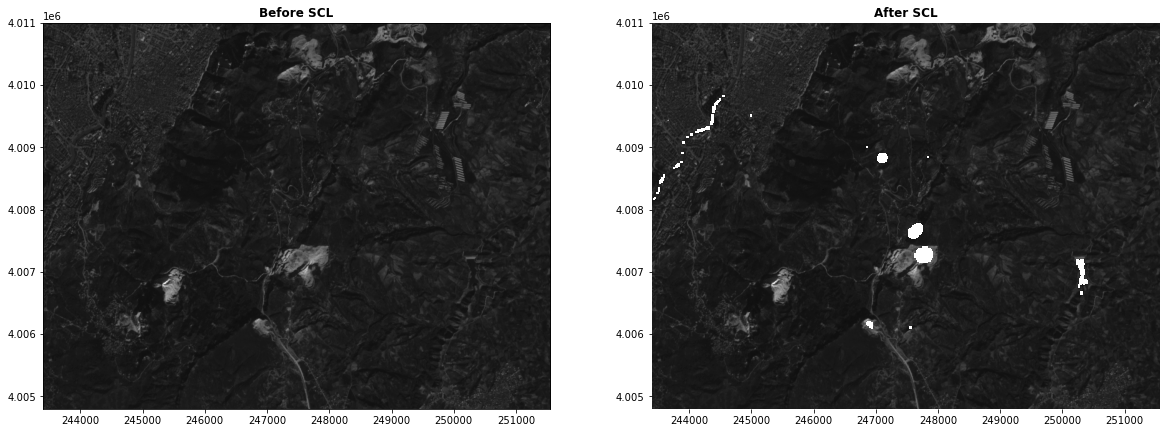

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))


im_file_clip = glob.glob(f'{clipped_path}*20230209*B04*.tif')[0]

src = rasterio.open(im_file_clip, "r")
rasterio.plot.show(src, ax=ax1, cmap='Greys_r', title="Before SCL")


im_file_scl = glob.glob(f'{masked_path}*20230209*B04*.tif')[0]

src = rasterio.open(im_file_scl, "r")
rasterio.plot.show(src, ax=ax2, cmap='Greys_r', title="After SCL")

plt.box(False)

## Landslides detection analysis

This section includes the landslide analysis. It is divided into four sub-points. 

The first one is the choice of the index to be calculated. The second one selects the bands needed for the calculation of the chosen index. Then follows the implementation of the algorithm used to calculate the index for each pixel of the image. Finally, the two images used to predict the change in the index between the two dates.

### Choice of parameters

In [43]:
index_name = 'ARVI'

nodata_val = -10000

print(f'You chose to compute {index_name} !')

index_path = f'{work_path}{index_name}/'
index_calc_path = f'{work_path}{index_name}_CALC/'
index_vali = f'{work_path}{index_name}_VALI/'
landslides = f'{work_path}LANDSLIDES_VALI/'

Path(index_path).mkdir(parents=True, exist_ok=True)
Path(index_calc_path).mkdir(parents=True, exist_ok=True)
Path(index_vali).mkdir(parents=True, exist_ok=True)

You chose to compute ARVI !


### Choice of bands

In [17]:
if index_name == 'NDVI':
    bands_needed = ['B04','B08']
    list_im_path = [reflectance_path,
                    reflectance_path]

elif index_name == 'ARVI':
    bands_needed = ['B02','B04','B08']
    list_im_path = [reflectance_path,
                    reflectance_path,
                   reflectance_path]

print(f'To compute {index_name} you need : {bands_needed}')

To compute ARVI you need : ['B02', 'B04', 'B08']


In [18]:
for i,band in enumerate(bands_needed):
    
    print(f'We need band/index {band} to compute {index_name}')
    list_im = glob.glob(f'{list_im_path[i]}*{band}*.tif')
    
    print(list_im)
    
    nb_im = len(list_im)
    print(f'--> {nb_im} images are found \n')

print('Check if the number of images found for each band/index is the same !!')

We need band/index B02 to compute ARVI
['C:/Users/Thonnard Julien/LBRAT2104/GROUP_7/OUTPUT/3_L2A_MASKED\\T37SBA_20230125T082129_B02_10m_ROI_SCL.tif', 'C:/Users/Thonnard Julien/LBRAT2104/GROUP_7/OUTPUT/3_L2A_MASKED\\T37SBA_20230209T082111_B02_10m_ROI_SCL.tif']
--> 2 images are found 

We need band/index B04 to compute ARVI
['C:/Users/Thonnard Julien/LBRAT2104/GROUP_7/OUTPUT/3_L2A_MASKED\\T37SBA_20230125T082129_B04_10m_ROI_SCL.tif', 'C:/Users/Thonnard Julien/LBRAT2104/GROUP_7/OUTPUT/3_L2A_MASKED\\T37SBA_20230209T082111_B04_10m_ROI_SCL.tif']
--> 2 images are found 

We need band/index B08 to compute ARVI
['C:/Users/Thonnard Julien/LBRAT2104/GROUP_7/OUTPUT/3_L2A_MASKED\\T37SBA_20230125T082129_B08_10m_ROI_SCL.tif', 'C:/Users/Thonnard Julien/LBRAT2104/GROUP_7/OUTPUT/3_L2A_MASKED\\T37SBA_20230209T082111_B08_10m_ROI_SCL.tif']
--> 2 images are found 

Check if the number of images found for each band/index is the same !!


### Index computaion

In [19]:
# The purpose of this loop is to compute the spectral index for all the images of the timeserie
for i in range(0,nb_im):
    
    # Find the image filename and the associated date (available in the filename)
    im   = sorted(glob.glob(f'{list_im_path[0]}*{bands_needed[0]}*.tif'))[i]
    date = os.path.basename(im)[7:15]
    
    print(f'Date : {date}')

    # Start a list to gather all the spectral bands you will need to compute the spectral index
    list_im = [im]

    # Then we need to find the other spectral band needed to compute the spectral index and add it to the list
    for n,band in enumerate(bands_needed[1:]):
        im = glob.glob(f'{list_im_path[n+1]}*{date}*{band}*.tif')[0]
        list_im.append(im)

    # Name the output spectral indice file
    index_file = f'{index_path}{os.path.basename(list_im[0])[0:22]}_{index_name}.tif'
    
    # If the spectral index for this data does not exist --> create it
    if  not os.path.isfile(index_file):
        
        # Create a list with all reflectance images needed to compute the spectral index in Numpy array
        list_im_arr = []

        for im_file in list_im:

            # Open band and update metadata
            src = rasterio.open(im_file, 'r')
            profile = src.profile
            profile.update(dtype=rasterio.float64)
            im = src.read(1)

            # Convert no-data value into Numpy NaN
            im = im.astype(float)
            im[im == nodata_val] = np.nan
            
            src.close()

            list_im_arr.append(im)
        
        # Compute the Spectral Index you have selected
        
        if index_name == 'NDVI':
            red = list_im_arr[0] # B04
            nir = list_im_arr[1] # B08

            index_arr = (nir - red) / (nir + red)
            
            df = pd.DataFrame(index_arr)
            df = df[df.iloc[:,:] < 0.3]
            index_arr_bis = df.to_numpy()
            

        elif index_name == 'ARVI':
            blue  = list_im_arr[0] # B02
            red   = list_im_arr[1] # B04
            nir   = list_im_arr[2] # B08

            index_arr = (nir - (2*red) + blue) / (nir + (2*red) + blue)  #(NIR – (2 * Red) + Blue) / (NIR + (2 * Red) + Blue) 
            
            df = pd.DataFrame(index_arr)
            df = df[df.iloc[:,:] < 0.3]
            index_arr_bis = df.to_numpy()
        
        # Write Spectral Index image into GeoTIFF

        dst = rasterio.open(index_file, "w", **profile)
        dst.write(index_arr_bis,1)
        dst.close()

        print(f'A new {index_name} file is created : {index_file}')
    

print(f'--> All {index_name} are computed !')

Date : 20230125
Date : 20230209
--> All ARVI are computed !


In [20]:
date = '20230209'

im_file = glob.glob(f'{index_path}*{date}*.tif')[0]

print(im_file)
src = rasterio.open(im_file, "r")

C:/Users/Thonnard Julien/LBRAT2104/GROUP_7/OUTPUT/ARVI\T37SBA_20230209T082111_ARVI.tif


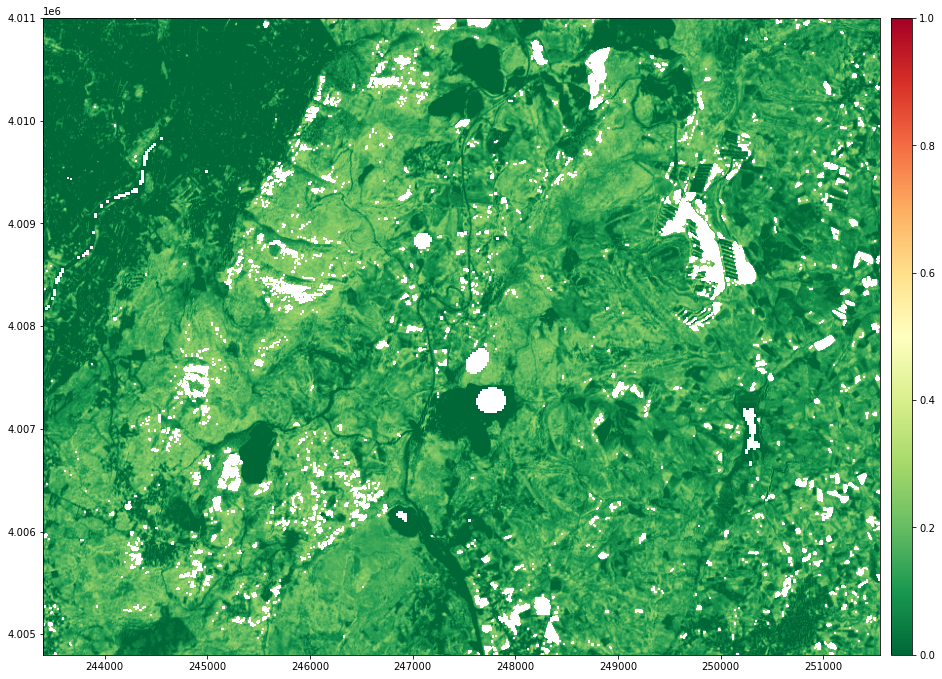

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

color_map = plt.cm.get_cmap("RdYlGn")
reversed_color_map = color_map.reversed()


im_rio = rasterio.plot.show(src, cmap=reversed_color_map, vmin=0, vmax=1, ax=ax)
im_rio = im_rio.get_images()[0]

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im_rio, ax=ax, cax=cax)

plt.box(False)

### Index change computation

In [22]:
# Choose the two dates you want to subtract
date_1 = '20230125'
date_2 = '20230209'

# Choose the treshold you want for the keeping values
treshold = -0.06

In [23]:
# Get the spectral indices associated with the dates you have chosen
index_file_1 = glob.glob(f'{index_path}*{date_1}*.tif')[0]
index_file_2 = glob.glob(f'{index_path}*{date_2}*.tif')[0]

# Name the output index file
index_file_diff = f'{index_calc_path}{index_name}_{date_2}_MINUS_{date_1}_{treshold}.tif'

if not os.path.isfile(index_file_diff):

    # Open the spectral index at date 1
    src = rasterio.open(index_file_1, 'r')
    profile = src.profile
    date_1_arr = src.read(1)
    src.close()

    # Open the spectral index at date 2
    src = rasterio.open(index_file_2, 'r')
    date_2_arr = src.read(1)
    src.close()

    # Compute the difference between date 2 and date 1 
    diff_index = date_2_arr - date_1_arr
    df = pd.DataFrame(diff_index)
    df = df[df.iloc[:,:] <= treshold]
    diff_index_biss = df.to_numpy()

    # Write the output in GeoTIFF
    dst = rasterio.open(index_file_diff, "w", **profile)
    dst.write(diff_index_biss,1)
    dst.close()
    
    print(f'A new {index_file_diff} file is created : {index_file_diff}')
    
else:
    print(f'--> {index_file_diff} - already exists')

--> C:/Users/Thonnard Julien/LBRAT2104/GROUP_7/OUTPUT/ARVI_CALC/ARVI_20230209_MINUS_20230125_-0.06.tif - already exists


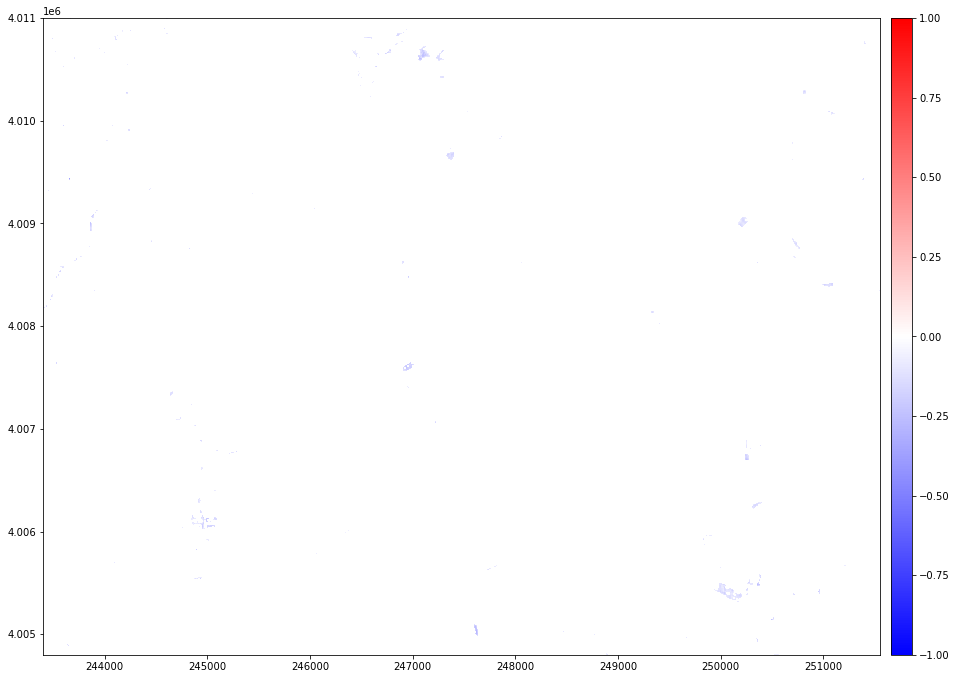

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(15,15))

color_map = plt.cm.get_cmap("bwr")

src = rasterio.open(index_file_diff, "r")
im_rio = rasterio.plot.show(src, cmap=color_map, vmin=-1, vmax=1, ax=ax)
im_rio = im_rio.get_images()[0]

cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(im_rio, ax=ax, cax=cax)

plt.box(False)

### Validation

We first need to extract all the validation points coordinates which are stocked wierdly in our shapefile


In [44]:
validation = gpd.read_file(f'{landslides}landslides.shp')

coord = pd.DataFrame()
for i in range(len(validation)):
    
    # Channel with coordinates
    string = str(validation.iloc[i,3])
    
    # Expression to extract the coordinates 
    match = re.search(r'\((\d+\.\d+)\s+(\d+\.\d+)\)', string)
    if match:
        # Coordinates stackerd
        x_coord = float(match.group(1))
        y_coord = float(match.group(2))
        
        # Dataframe with different coordinates
        df = pd.DataFrame({'x_coord': [x_coord], 'y_coord': [y_coord]})
        coord = pd.concat([coord,df])
    else:
        print("Pas de correspondance trouvee.")

labels = pd.concat([validation['Latitude'], validation['Landslides']]).dropna()
labels = labels.reset_index(drop=True)
coord = coord.reset_index(drop=True)
Validation_complet = pd.concat([coord,labels],axis = 1)
Validation_complet = Validation_complet.set_axis(['x_coord', 'y_coord', 'labels'], axis = 1)

Then we can look for the values assigned to these points for the ARVI tiff

In [45]:
## Dataset landslides
ds = gdal.Open(f'{index_calc_path}{index_name}_20230209_MINUS_20230125_-0.06.tif')
data = ds.GetRasterBand(1)
data = data.ReadAsArray()
geotransform = ds.GetGeoTransform()
ds = None

# Convert the geographical coordinate to pixels position
pixels_coord = pd.DataFrame()
for i in range(len(Validation_complet)):
    
    x = floor((Validation_complet.iloc[i,0] - geotransform[0])/geotransform[1])
    y = floor((Validation_complet.iloc[i,1] - geotransform[3])/geotransform[5])
    value = data[y,x]
    
    df = pd.DataFrame({'x_coord': [x], 'y_coord': [y],'labels': [value]})
    pixels_coord = pd.concat([pixels_coord,df])

labels_Validation_complet = pd.DataFrame(Validation_complet.iloc[:,2])
labels_pixels_coord = pd.DataFrame(pixels_coord.iloc[:,2])
labels_pixels_coord = labels_pixels_coord.fillna(0).applymap(lambda x: 0 if x == 0 else 1.0)

# Printing the confusion matrix and validation metrics 
cm = confusion_matrix(labels_Validation_complet, labels_pixels_coord)
print('L\C 0   1')
print(' 0'+ str(cm[0]) + '\n 1' + str(cm[1]))
print('Accuracy : ' + str(accuracy_score(labels_Validation_complet, labels_pixels_coord)))
print(classification_report(labels_Validation_complet, labels_pixels_coord))

L\C 0   1
 0[58  2]
 1[23 37]
Accuracy : 0.7916666666666666
              precision    recall  f1-score   support

         0.0       0.72      0.97      0.82        60
         1.0       0.95      0.62      0.75        60

    accuracy                           0.79       120
   macro avg       0.83      0.79      0.79       120
weighted avg       0.83      0.79      0.79       120



## Ground displacement analysis (SNAP)

You will find below the different steps applied in order to obtain the analysis product concerning the ground displacements.

In SNAP : 
1)	Install the "Statistical-cost network-flow algorithm for phase unwrappin *(SNAPHU)*" plugin.
2)	Open both products to use for the interferogram.
3)	S-1 TOPS Split: Select the region of interest with VV polarisation *(Radar >Sentinel-1 TOPS> S-1 TOPS Split)*.
4)	Apply the "Precise" Orbit file *(Radar> Apply Orbit File)*.
5)	Coregistration of both products: Select the "SRTM 1Sec HGT (AutoDownload)" in the Back-Geocoding table *(Radar > Coregistration > Sentinel-1 TOPS Coregistration> S-1 Back geocoding operator)*.
6)	Increasing the quality of the coregistration (Radar > Coregistration > Sentinel-1 TOPS Coregistration > S-1 Enhanced Spectral Diversity).
7)	Removing the burst delimitations *(Radar > Sentinel-1 TOPS > S-1 TOPS Deburst operator)*.
8)	Phase filtering *(Radar > Interferometric > Filtering > Goldstein Phase Filtering)*.
9)	Subset *(Raster > Subset)*.
10)	Export operator for Snaphu: select "DEFO" as statistical-cost model and "200" for the Row Overlap and Column Overlap *(Radar > Interferometric > Unwrapping > Export operator)*.
11)	Unwrapping with Snaphu *(Radar > Interferometric > Unwrapping > Snaphu-unwrapping operator)*.
12)	Import operator for Snaphu *(Radar> Interferometric > Unwrapping > Snaphu import)*.
13)	Conversion of the radian units into absolute displacements *(Radar > Interferometric > Phase to Displacement operator)*.
14)	Terrain correction: select SRTM 1SecHGT *(AutoDownload)* as input DEM *(Radar > Geometric > Terrain Correction > Range Dopple Terrain Correction operator)*.
15)	Masking out low coherence pixels: apply a threshold of 60% of coherence with "coherence_VV > 0.6" *(Product > Properties > Valid-Pixel Expression)*.
16)	Export to GeoTIFF format.

In QGIS :
1)	Raster to points *(Processing > Toolbox > Vector creation > Raster to points)*.
2)  Interpolation *(Processing > Toolbox > Interpolation > IDW Interpolation)*.


## Urban damages analysis (SNAP)

1)	Data loading.
2)	Create a subset: Select the region of interest and save product to "BEAM-DIMMAP" *(Product > Spatial Subset from View)*.
3)	Apply Orbit File *(Radar > Apply Orbit File)*.
4)	Calibration of the products, select the VV polarization from the processing parameters tab and leave "Output sigma0 band" checked *(Radar > Radiometric > Calibration)*.
5)	Speckle Filter: select the "Refined Lee" as filter *(Radar > Speckle Filtering > Single Product Speckle Filter)*.
6)	Terrain Correction *(Radar > Geometric > Terrain Correction > Range-Doppler Terrain Correction)*.
7)	Linear Conversion to/from dB *(Raster > Data Conversion > Converts bands to/from dB)*.
8)	Create stack *(Radar > Coregistration > Stack tools > Create stack)*.
9)	Change detection *(Radar > SAR Applications > Change Detection)*.
10)	Export as GeoTIFF *(File > Export > GeoTIFF)*.